<a href="https://colab.research.google.com/github/simsekergun/SubstrateOptimization/blob/main/FDFD_Adjoint_10layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']=100
import matplotlib.pylab as plt
import numpy as np

In [2]:
!git clone https://github.com/simsekergun/fdfd.git
import fdfd

Cloning into 'fdfd'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 30 (delta 8), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (30/30), 24.99 KiB | 12.49 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [3]:
# Some python notebook magic to automatically reload src files
%load_ext autoreload
%autoreload 2

In [4]:
from fdfd import assign_val, driven
import progressbar

In [5]:
# random number generator
rng = np.random.default_rng(47)

In [6]:
# Number of x,y grid points in domain
Nx = 240 # must be divisible by 8 and 12
Ny = 200 # must be divisible by 8 and 12
N = (Nx, Ny)
Nlayer = 10 # number of thin films
dlayer = 120e-9
wavelength = 600e-9
freq = 3e8/wavelength
dL = 10e-9

iLayer = int(np.round(dlayer/dL))

# Spatial ranges for the domain (m)
xrange = 2.4e-6
yrange = 2.4e-6

x_range = (-0.75*xrange, 0.25*xrange)
y_range = (-0.5*yrange, 0.5*yrange)

# Angular frequency of source (rad/s)
omega = 2*np.pi*freq

# Define the relative permittivity of the region (adding 10 layers along x-axis)
eps_r = np.ones(N)
eps_random = 2.0+rng.random(Nlayer)

for ii in range(10):
  eps_r[int(Nx/4)+ii*iLayer:int(Nx/4)+iLayer+ii*iLayer,:] = eps_random[ii]

# Define the point source
Jz = np.zeros(N, dtype=complex)
Jz[int(Nx/8), int(Ny/2)] = 1

Npml = (int(Nx/12), int(Nx/12))

In [7]:
print(rng.random(Nlayer))

[0.75046458 0.79297822 0.55382891 0.82173825 0.61086885 0.43368951
 0.31032977 0.71442677 0.90217468 0.19361897]


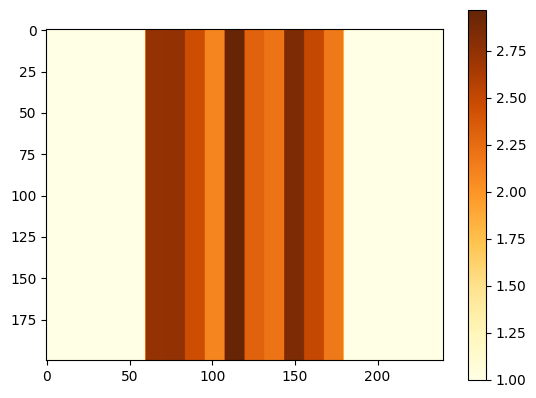

In [8]:
plt.imshow(np.real(eps_r).T, cmap = "YlOrBr")
cbar = plt.colorbar()
cbar.solids.set_edgecolor("face")

In [9]:
# solve for the fields in our domain with FDFD
(Ez,Hx,Hy) = driven.solve_TM(omega, x_range, y_range, eps_r, Jz, Npml)

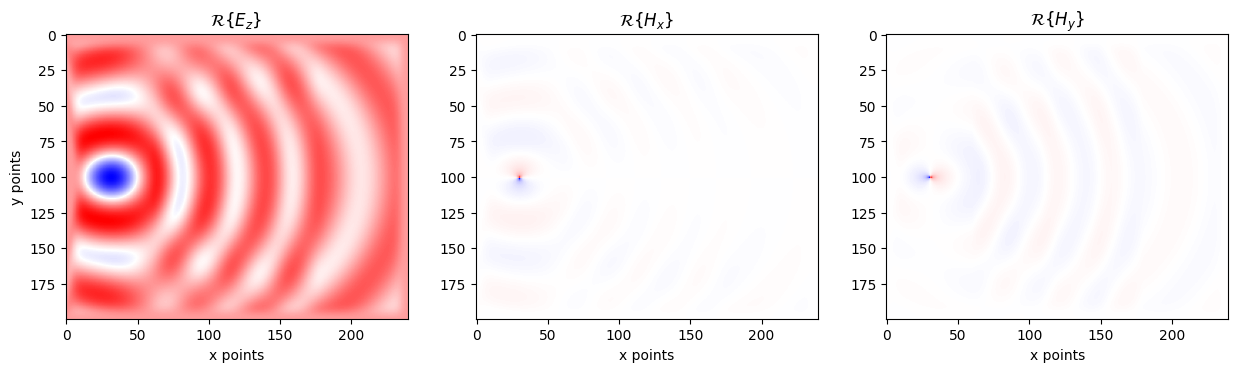

In [10]:
# plot the field components
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
# Ezplt = ax1.imshow(np.real(Ez[0]).T, cmap = "bwr", vmin = -3e-7, vmax = 3e-7)
Ezplt = ax1.imshow(np.real(Ez[0]).T, cmap = "bwr")
Hxplt = ax2.imshow(np.real(Hx[0]).T, cmap = "bwr")
Hyplt = ax3.imshow(np.real(Hy[0]).T, cmap = "bwr")
ax1.set_title('$\mathcal{R}\{ E_z \}$')
ax2.set_title('$\mathcal{R}\{ H_x \}$')
ax3.set_title('$\mathcal{R}\{ H_y \}$')
ax1.set_xlabel('x points')
ax2.set_xlabel('x points')
ax3.set_xlabel('x points')
ax1.set_ylabel('y points')
plt.show()

In [11]:
eta = 1.0

Jz_aj = np.zeros(N, dtype=complex)
Jz_aj[int(7*Nx/8), int(Ny/2)] = -2*np.conj(Ez[0,int(7*Nx/8), int(Ny/2)])/1j/omega

(Ez_aj,Hx_aj,Hy_aj) = driven.solve_TM(omega, x_range, y_range, eps_r, Jz_aj, Npml)

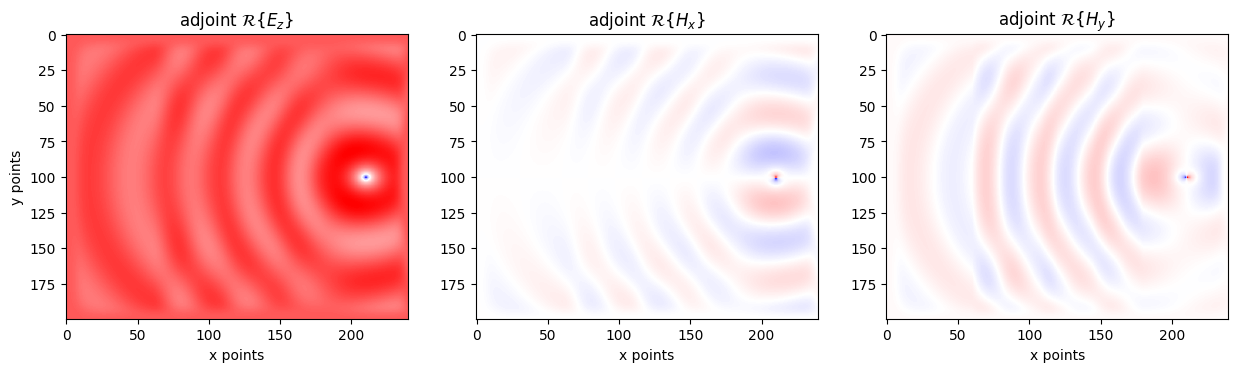

In [12]:
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
Ezplt = ax1.imshow(np.real(Ez_aj[0]).T, cmap = "bwr")
Hxplt = ax2.imshow(np.real(Hx_aj[0]).T, cmap = "bwr")
Hyplt = ax3.imshow(np.real(Hy_aj[0]).T, cmap = "bwr")
ax1.set_title('adjoint $\mathcal{R}\{ E_z \}$')
ax2.set_title('adjoint $\mathcal{R}\{ H_x \}$')
ax3.set_title('adjoint $\mathcal{R}\{ H_y \}$')
ax1.set_xlabel('x points')
ax2.set_xlabel('x points')
ax3.set_xlabel('x points')
ax1.set_ylabel('y points')
plt.show()

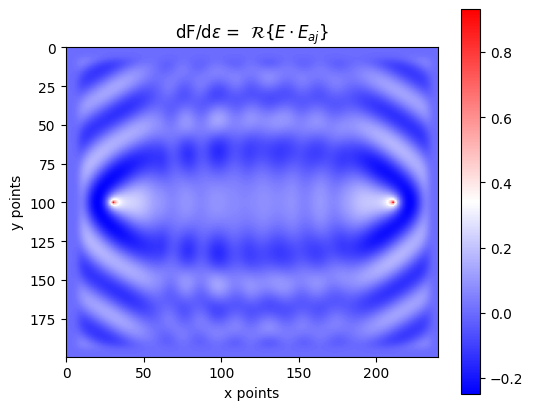

In [13]:
#plot the sensitivity map
f = plt.figure(figsize=(6,5))
max_abs = np.max(np.max(np.abs(Ez_aj[0]*Ez[0])))
Ezplt = plt.imshow(np.real(Ez_aj[0]*Ez[0]/max_abs).T, cmap = "bwr")
plt.title('dF/d$\epsilon$ =  $\mathcal{R}\{ E \cdot E_{aj} \}$')
plt.xlabel('x points')
plt.ylabel('y points')
plt.colorbar()
plt.show()

In [14]:
# calculate the overlap
EE = np.real(Ez_aj[0]*Ez[0])*omega*omega*8.854e-12
# do the sums over each layer
delta_eps_r = np.zeros(Nlayer)
for ii in range(Nlayer):
  delta_eps_r[ii] = delta_eps_r[ii] + 1e15*np.sum(EE[int(Nx/4)+ii*iLayer:int(Nx/4)+iLayer+ii*iLayer,:])
delta_eps_r

array([-0.03745224, -0.04727305,  0.02786781, -0.02788111, -0.00341118,
        0.07174156, -0.02372327,  0.03322033,  0.05960569, -0.03298055])

In [15]:
current_E_field_0 = np.abs(Ez[0,int(7*Nx/8), int(Ny/2)])
E0 = current_E_field_0

for jj in range(50):

  for ii in range(10):
    eps_r[int(Nx/4)+ii*iLayer:int(Nx/4)+iLayer+ii*iLayer,:] = eps_r[int(Nx/4)+ii*iLayer:int(Nx/4)+iLayer+ii*iLayer,:]+delta_eps_r[ii]
  eps_r[eps_r>4.0] = 4.0
  # uncomment if you want to display the permittivity values
  # print(eps_r[int(Nx/4)+iLayer*np.arange(Nlayer),0])

  # solve for the fields in our domain with FDFD
  (Ez,Hx,Hy) = driven.solve_TM(omega, x_range, y_range, eps_r, Jz, Npml)
  # display the current E field value at the target
  current_E_field = np.abs(Ez[0,int(7*Nx/8), int(Ny/2)])
  print(current_E_field/E0)

  # if the difference is so small, stop iterating
  if np.abs(current_E_field_0-current_E_field)/np.abs(current_E_field_0)<1e-4:
    break
  else:
    current_E_field_0 = current_E_field

  Jz_aj = np.zeros(N, dtype=complex)
  Jz_aj[int(7*Nx/8), int(Ny/2)] = -2*np.conj(Ez[0,int(7*Nx/8), int(Ny/2)])/1j/omega

  (Ez_aj,Hx_aj,Hy_aj) = driven.solve_TM(omega, x_range, y_range, eps_r, Jz_aj, Npml)

  EE = np.real(Ez_aj[0]*Ez[0])*omega*omega*8.854e-12

  delta_eps_r = np.zeros(Nlayer)
  for ix in range(Nlayer):
    delta_eps_r[ix] = delta_eps_r[ix] + np.sum(EE[int(Nx/4)+ix*iLayer:int(Nx/4)+iLayer+ix*iLayer,:])/dL/dL


1.0109602045270134
0.9978599479282477
1.0319898727463825
1.0131441063127111
1.042646658348698
1.0328508822728002
1.0661831631569063
1.0655862387548272
1.0758149521821425
1.0748708904275166
1.0738663329103557
1.0733493812931265
1.073050482305205
1.0728681211274111
1.072753513378227
1.0726802048362996


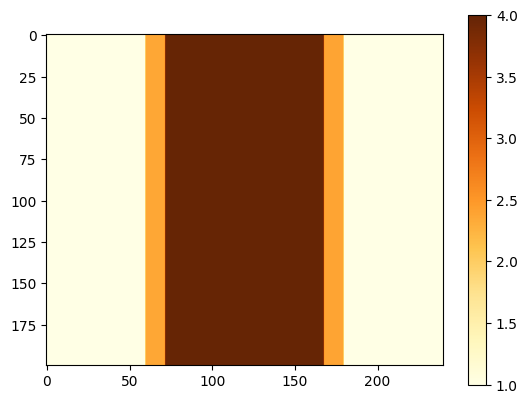

In [16]:
plt.imshow(np.real(eps_r).T, cmap = "YlOrBr")
cbar = plt.colorbar()
cbar.solids.set_edgecolor("face")

In [17]:
eps_r[int(Nx/4)+iLayer*np.arange(Nlayer),0]

array([2.38060413, 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 2.39609143])

In [18]:
!rm -r fdfd